In [45]:
import pandas as pd
import string
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer(reduce_len=True)

# Feature Engineering

In [9]:
# read the raw data and show the data
raw_data = pd.read_csv("./ExtractedTweets.csv")
raw_data.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


In [21]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def remove_punctuations(t):
    t = re.sub('@\w+','', t)
    t = "".join([char for char in t if char not in string.punctuation])
    t = re.sub('[0-9]+', '', t)
    return t

def tokenization(t):
    t = re.split('\W+', t)
    return t

def remove_stop_words(t):
    t = [word for word in t if word not in stopword]
    t = [word for word in t if word not in ['rt']]
    return t

def stemming(t):
    t = [ps.stem(word) for word in t]
    return t

In [31]:
def cleaner(t):
    t = remove_punctuations(t).lower()
    t = tokenization(t)
    t = remove_stop_words(t)
    t = stemming(t)
    return t

In [34]:
raw_data['cleaned'] = raw_data.Tweet.apply(lambda x: " ".join(cleaner(x)))
raw_data.head(10)

,Party,Handle,Tweet,cleaned
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senat dem vote savetheinternet proud sup...
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winter resid alta vista teacher one sever reco...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,note hurrican maria left approxim billion dama...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,meet thank take time meet ed marucci guzman na...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,hurrican season start june st puerto rico read...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,thank came orlando gala success night would po...
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,hurrican maria left approx billion damag yet b...
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,delight vote cra overrul fcc save netneutr rul...
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...,trump antiimmigr polici hurt small busi across...
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...,great join roundtabl orlando feder issu affect...


In [35]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.cleaned,raw_data.Party, stratify=raw_data.Party, test_size = 0.2, random_state=123)

# Model Selection

In [40]:
nb_pipleline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', MultinomialNB())
])

In [41]:
nb_pipleline.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f82518b8668>>)),
                ('classifier', MultinomialNB())])

In [42]:
preds = nb_pipleline.predict(X_test)
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, preds), 4))))

Accuracy: 0.7554


## Gridsearch on naive bayes

In [43]:
nb_params = [{'classifier__alpha': [3,2,1,0.1, 0.01, 0.001, 0.0001, 0.00001]}]
gs = GridSearchCV(estimator=nb_pipleline, param_grid=nb_params, refit=True, cv=4, n_jobs=-1)
gs.fit(X_train, y_train)
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

Best Accuracy: 75.94%
Best Params: {'classifier__alpha': 0.1}


<BarContainer object of 8 artists>

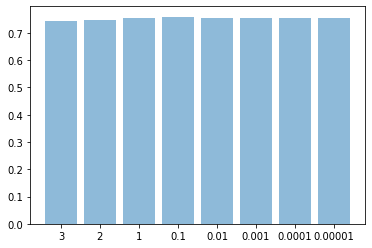

In [44]:
plt.bar(['3','2','1','0.1', '0.01', '0.001', '0.0001', '0.00001'],gs.cv_results_['mean_test_score'],align='center', alpha=0.5 )

## SVM

In [46]:
svm_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', SVC())
])

svm_scores = cross_val_score(svm_pipe, X_train, y_train, cv=4, n_jobs=-1)
svm_scores

array([0.76497802, 0.76457321, 0.76214434, 0.76544067])

## Randomnized search on XGBoost

In [50]:
import scipy.stats

d = {'classifier__max_depth':[5,6,7,8,9,10],
     'classifier__min_child_weight': scipy.stats.uniform(loc=0, scale=10),
     'classifier__eta': scipy.stats.uniform(loc=0, scale=2)}

In [51]:
xgb_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.2, nthreads=-1))
])

rs = RandomizedSearchCV(estimator=xgb_pipe, param_distributions=d, n_iter=10, cv=4, refit=True, random_state=123, n_jobs=-1)

In [53]:
xgb_pipe.fit(X_train, y_train)
xgb_preds = xgb_pipe.predict(X_test)

## Model Evaluation